In [9]:
from keras.utils import image_dataset_from_directory
from keras.preprocessing.image import array_to_img
from keras.applications import ResNet50, ResNet101, EfficientNetB0, VGG16
import os
from PIL import Image
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from keras.models import Model
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
import pandas as pd
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# interpolation with bicubic spline

input_dir = "../data/seg_train"
output_dir = "../data/seg_train_resized"

os.makedirs(output_dir, exist_ok=True)


def resize_and_save_images(input_dir, output_dir, target_size):
    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if os.path.isdir(class_path):  
            class_output_path = os.path.join(output_dir, class_name)
            os.makedirs(class_output_path, exist_ok=True)

            for filename in os.listdir(class_path):
                input_path = os.path.join(class_path, filename)
                output_path = os.path.join(class_output_path, filename)

            
                try:
                    with Image.open(input_path) as img:
                        img = img.resize(target_size, Image.BICUBIC)
                        img.save(output_path)
                except Exception as e:
                    print(f"Error processing {input_path}: {e}")

resize_and_save_images(input_dir, output_dir, target_size=(224, 224))

print(f"All images have been resized and saved to {output_dir}.")


# resnet50

Found 11231 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Building model for ResNet50
Training ResNet50
Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 71s 179ms/step - accuracy: 0.7077 - loss: 4.1290 - val_accuracy: 0.8627 - val_loss: 1.2356
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 62s 174ms/step - accuracy: 0.7851 - loss: 1.2276 - val_accuracy: 0.8431 - val_loss: 0.7956
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 61s 172ms/step - accuracy: 0.7886 - loss: 0.9045 - val_accuracy: 0.8524 - val_loss: 0.6881
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 71s 201ms/step - accuracy: 0.8009 - loss: 0.8271 - val_accuracy: 0.8531 - val_loss: 0.6766
Epoch 5/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 61s 171ms/step - accuracy: 0.7986 - loss: 0.8212 - val_accuracy: 0.8670 - val_loss: 0.6493
Epoch 6/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 61s 172ms/step - accuracy: 0.8009 - loss: 0.8100 - val_accuracy: 0.8402 - val_loss: 0.6922
Epoch 7/100
351/351 ━━━━━━━━━━━━━━━

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 234ms/step - accuracy: 0.8816 - loss: 0.4182
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step
ResNet50 - Test Loss: 0.4415800869464874, Test Accuracy: 0.8769999742507935
ResNet50 - Test Precision: 0.8765158618335818, Recall: 0.877, F1: 0.8753886600642052, AUC: 0.9860321715177306


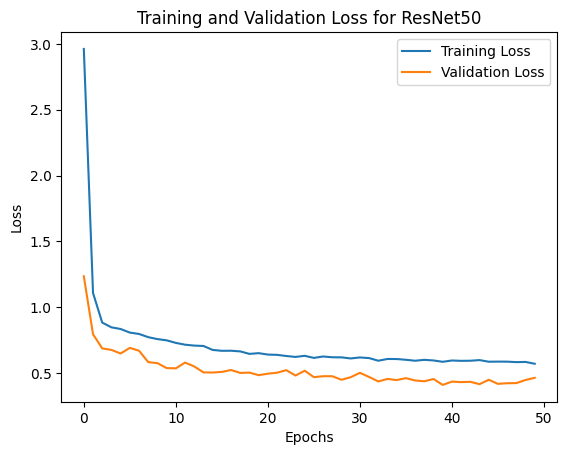

In [7]:


input_shape = (224, 224, 3)
batch_size = 32
epochs = 100

# Data augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomCrop(200, 200),  # Adjusted cropping dimensions
    tf.keras.layers.Resizing(224, 224),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

# Data generators
train_datagen = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    '../data/seg_train_resized',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '../data/seg_train_resized',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

test_generator = test_datagen.flow_from_directory(
    '../data/deg_test',  # Test data directory
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important for consistency
)




# Build model function
def build_model(base_model):
    base_model.trainable = False  # Freeze base model
    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=predictions)
    return model

# Base models
base_models = {
    "ResNet50": ResNet50(weights='imagenet', include_top=False, pooling='avg')
}

models = {}
training_history = {}

# Training loop
for name, base_model in base_models.items():
    print(f"Building model for {name}")
    model = build_model(base_model)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    print(f"Training {name}")
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=[early_stopping]
    )

    models[name] = model
    training_history[name] = history

    # Evaluate training and validation metrics
    y_train_true = train_generator.classes
    y_train_pred_proba = model.predict(train_generator)

    y_val_true = validation_generator.classes
    y_val_pred_proba = model.predict(validation_generator)

    # Convert true labels to one-hot encoded for AUC calculation
    y_train_true_bin = label_binarize(y_train_true, classes=range(train_generator.num_classes))
    y_val_true_bin = label_binarize(y_val_true, classes=range(validation_generator.num_classes))

    # Calculate metrics
    train_auc = roc_auc_score(y_train_true_bin, y_train_pred_proba, average='weighted', multi_class='ovr')
    val_auc = roc_auc_score(y_val_true_bin, y_val_pred_proba, average='weighted', multi_class='ovr')

    train_precision = precision_score(y_train_true, np.argmax(y_train_pred_proba, axis=1), average='weighted')
    train_recall = recall_score(y_train_true, np.argmax(y_train_pred_proba, axis=1), average='weighted')
    train_f1 = f1_score(y_train_true, np.argmax(y_train_pred_proba, axis=1), average='weighted')

    val_precision = precision_score(y_val_true, np.argmax(y_val_pred_proba, axis=1), average='weighted')
    val_recall = recall_score(y_val_true, np.argmax(y_val_pred_proba, axis=1), average='weighted')
    val_f1 = f1_score(y_val_true, np.argmax(y_val_pred_proba, axis=1), average='weighted')

    print(f"{name} - Training Precision: {train_precision}, Recall: {train_recall}, F1: {train_f1}, AUC: {train_auc}")
    print(f"{name} - Validation Precision: {val_precision}, Recall: {val_recall}, F1: {val_f1}, AUC: {val_auc}")
    
    test_loss, test_accuracy = model.evaluate(test_generator)
    # Get true labels and predicted probabilities
    y_test_true = test_generator.classes
    y_test_pred_proba = model.predict(test_generator)
        
        # Convert true labels to one-hot encoded for AUC calculation
    y_test_true_bin = label_binarize(y_test_true, classes=range(test_generator.num_classes))
        
        # Calculate metrics
    test_auc = roc_auc_score(y_test_true_bin, y_test_pred_proba, average='weighted', multi_class='ovr')
    test_precision = precision_score(y_test_true, np.argmax(y_test_pred_proba, axis=1), average='weighted')
    test_recall = recall_score(y_test_true, np.argmax(y_test_pred_proba, axis=1), average='weighted')
    test_f1 = f1_score(y_test_true, np.argmax(y_test_pred_proba, axis=1), average='weighted')
    
    # Print metrics
    print(f"{name} - Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
    print(f"{name} - Test Precision: {test_precision}, Recall: {test_recall}, F1: {test_f1}, AUC: {test_auc}")
    
    break

# Plot training and validation errors
for name, history in training_history.items():
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"Training and Validation Loss for {name}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


In [18]:
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

# Class indices
class_labels = list(test_generator.class_indices.keys())

# Generate classification report
print("Classification Report:")
report = classification_report(y_test_true, y_test_pred, target_names=class_labels, digits=4)
print(report)

# Display confusion matrix
conf_matrix = confusion_matrix(y_test_true, y_test_pred)

# Convert confusion matrix to a DataFrame for better visualization
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
print("Confusion Matrix:")
print(conf_matrix_df)

model.save('/kaggle/working/resnet_50.keras')

Classification Report:
              precision    recall  f1-score   support

   buildings     0.8929    0.8970    0.8950       437
      forest     0.9892    0.9684    0.9787       474
     glacier     0.8440    0.7631    0.8015       553
    mountain     0.8186    0.7562    0.7861       525
         sea     0.8564    0.9706    0.9099       510
      street     0.8727    0.9301    0.9005       501

    accuracy                         0.8770      3000
   macro avg     0.8790    0.8809    0.8786      3000
weighted avg     0.8765    0.8770    0.8754      3000

Confusion Matrix:
           buildings  forest  glacier  mountain  sea  street
buildings        392       0        1         0    1      43
forest             1     459        1         1    2      10
glacier            4       2      422        85   35       5
mountain           6       3       69       397   43       7
sea                4       0        7         1  495       3
street            32       0        0         1   

# resnet101

Found 3000 images belonging to 6 classes.
Found 11231 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Building model for ResNet101
Training ResNet101
Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


176/176 ━━━━━━━━━━━━━━━━━━━━ 113s 556ms/step - accuracy: 0.6963 - loss: 4.2282 - val_accuracy: 0.7807 - val_loss: 1.1032
Epoch 2/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 94s 526ms/step - accuracy: 0.7641 - loss: 1.1405 - val_accuracy: 0.8203 - val_loss: 0.8903
Epoch 3/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 94s 526ms/step - accuracy: 0.7671 - loss: 1.0600 - val_accuracy: 0.8470 - val_loss: 0.8335
Epoch 4/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 93s 524ms/step - accuracy: 0.7742 - loss: 1.0207 - val_accuracy: 0.8113 - val_loss: 0.8524
Epoch 5/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 94s 526ms/step - accuracy: 0.7896 - loss: 0.8933 - val_accuracy: 0.8499 - val_loss: 0.6584
Epoch 6/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 94s 526ms/step - accuracy: 0.7913 - loss: 0.8155 - val_accuracy: 0.8577 - val_loss: 0.6336
Epoch 7/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 94s 526ms/step - accuracy: 0.7847 - loss: 0.7947 - val_accuracy: 0.8606 - val_loss: 0.6002
Epoch 8/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 94s 525ms/step - accuracy: 0.7974 - loss: 0.76

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 447ms/step - accuracy: 0.8527 - loss: 0.4473
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 406ms/step
ResNet101 - Test Loss: 0.43986278772354126, Test Accuracy: 0.8610000014305115
ResNet101 - Test Precision: 0.864065265518082, Recall: 0.861, F1: 0.857654878700946, AUC: 0.9829224114965686


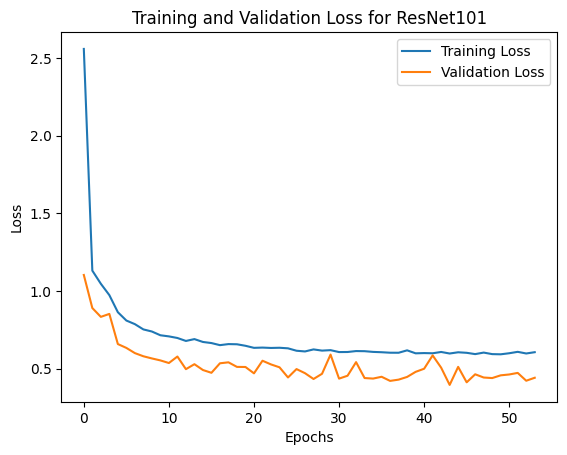

Classification Report:
              precision    recall  f1-score   support

   buildings     0.8709    0.8490    0.8598       437
      forest     0.9498    0.9979    0.9733       474
     glacier     0.8788    0.6293    0.7334       553
    mountain     0.7350    0.8400    0.7840       525
         sea     0.8976    0.9451    0.9207       510
      street     0.8619    0.9341    0.8966       501

    accuracy                         0.8610      3000
   macro avg     0.8657    0.8659    0.8613      3000
weighted avg     0.8641    0.8610    0.8577      3000

Confusion Matrix:
           buildings  forest  glacier  mountain  sea  street
buildings        371       5        0         0    3      58
forest             0     473        1         0    0       0
glacier            8       2      348       157   33       5
mountain           8      15       36       441   18       7
sea                8       2       11         2  482       5
street            31       1        0         0   

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=resnet_101.

In [20]:

train_datagen = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=tf.keras.applications.resnet.preprocess_input
)
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input
)

test_generator = test_datagen.flow_from_directory(
    '../data/deg_test', 
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False  # Important for consistency
)

train_generator = train_datagen.flow_from_directory(
    '../data/seg_train_resized',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '../data/seg_train_resized',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)



base_models = {
    "ResNet101": ResNet101(weights='imagenet', include_top=False, pooling='avg'),
}


for name, base_model in base_models.items():
    print(f"Building model for {name}")
    model = build_model(base_model)

    model.compile(optimizer=Adam(learning_rate=0.005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(f"Training {name}")

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=[early_stopping]
    )

    models[name] = model
    training_history[name] = history

    y_train_true = train_generator.classes
    y_train_pred_proba = model.predict(train_generator)

    y_val_true = validation_generator.classes
    y_val_pred_proba = model.predict(validation_generator)

    y_train_true_bin = label_binarize(y_train_true, classes=range(train_generator.num_classes))
    y_val_true_bin = label_binarize(y_val_true, classes=range(validation_generator.num_classes))

    train_auc = roc_auc_score(y_train_true_bin, y_train_pred_proba, average='weighted', multi_class='ovr')
    val_auc = roc_auc_score(y_val_true_bin, y_val_pred_proba, average='weighted', multi_class='ovr')

    train_precision = precision_score(y_train_true, np.argmax(y_train_pred_proba, axis=1), average='weighted')
    train_recall = recall_score(y_train_true, np.argmax(y_train_pred_proba, axis=1), average='weighted')
    train_f1 = f1_score(y_train_true, np.argmax(y_train_pred_proba, axis=1), average='weighted')

    val_precision = precision_score(y_val_true, np.argmax(y_val_pred_proba, axis=1), average='weighted')
    val_recall = recall_score(y_val_true, np.argmax(y_val_pred_proba, axis=1), average='weighted')
    val_f1 = f1_score(y_val_true, np.argmax(y_val_pred_proba, axis=1), average='weighted')

    print(f"{name} - Training Precision: {train_precision}, Recall: {train_recall}, F1: {train_f1}, AUC: {train_auc}")
    print(f"{name} - Validation Precision: {val_precision}, Recall: {val_recall}, F1: {val_f1}, AUC: {val_auc}")



    test_loss, test_accuracy = model.evaluate(test_generator)
 
    y_test_true = test_generator.classes
    y_test_pred_proba = model.predict(test_generator)
        
    y_test_true_bin = label_binarize(y_test_true, classes=range(test_generator.num_classes))
        
    test_auc = roc_auc_score(y_test_true_bin, y_test_pred_proba, average='weighted', multi_class='ovr')
    test_precision = precision_score(y_test_true, np.argmax(y_test_pred_proba, axis=1), average='weighted')
    test_recall = recall_score(y_test_true, np.argmax(y_test_pred_proba, axis=1), average='weighted')
    test_f1 = f1_score(y_test_true, np.argmax(y_test_pred_proba, axis=1), average='weighted')
        
    print(f"{name} - Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
    print(f"{name} - Test Precision: {test_precision}, Recall: {test_recall}, F1: {test_f1}, AUC: {test_auc}")

    name = "ResNet101"
    history = training_history.get(name)
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"Training and Validation Loss for {name}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

class_labels = list(test_generator.class_indices.keys())

print("Classification Report:")
report = classification_report(y_test_true, y_test_pred, target_names=class_labels, digits=4)
print(report)


conf_matrix = confusion_matrix(y_test_true, y_test_pred)

conf_matrix_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
print("Confusion Matrix:")
print(conf_matrix_df)

models['ResNet101'].save('resnet_101')


In [35]:
import numpy as np
from tensorflow.keras.callbacks import Callback

class ABELScheduler(Callback):
    def __init__(self, decay_factor=0.5, last_decay_epoch=10):
        super(ABELScheduler, self).__init__()
        self.decay_factor = decay_factor
        self.last_decay_epoch = last_decay_epoch
        self.reached_minimum = False
        self.previous_losses = [np.inf, np.inf]  # Initialize with two high losses
    
    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('loss')  # Retrieve the current loss
        # Shift the previous loss history and add the current loss
        self.previous_losses = [self.previous_losses[1], current_loss]
        
        # Calculate the loss differences
        loss_diff_t = self.previous_losses[1] - self.previous_losses[0]
        loss_diff_t_minus_1 = self.previous_losses[0] - self.previous_losses[1]
        
        # Implement the condition from the algorithm
        if loss_diff_t * loss_diff_t_minus_1 < 0:
            if self.reached_minimum:
                new_lr = self.decay_factor * self.model.optimizer.learning_rate.numpy()
                self.model.optimizer.learning_rate.assign(new_lr)
                print(f"Epoch {epoch+1}: Learning rate reduced to {new_lr}")
                self.reached_minimum = False
            else:
                self.reached_minimum = True
        else:
            self.reached_minimum = False
        
        # Check for the last decay epoch condition
        if epoch + 1 == self.last_decay_epoch:
            new_lr = self.decay_factor * self.model.optimizer.learning_rate.numpy()
            self.model.optimizer.learning_rate.assign(new_lr)
            print(f"Epoch {epoch+1}: Learning rate reduced to {new_lr} due to last_decay_epoch condition")




# EfficientNetB0 with custom learning rate decay(removed preprocessing function as documentation states it is included i the function)

Found 3000 images belonging to 6 classes.
Found 11231 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Building model for EfficientNetB0
Training EfficientNetB0
Epoch 1/100


2024-12-14 15:23:54.625570: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_21_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


88/88 ━━━━━━━━━━━━━━━━━━━━ 50s 434ms/step - accuracy: 0.7000 - loss: 4.6226 - val_accuracy: 0.8513 - val_loss: 1.0782
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.7885 - loss: 0.9954Epoch 2: Learning rate reduced to 0.0029999999329447745
88/88 ━━━━━━━━━━━━━━━━━━━━ 37s 400ms/step - accuracy: 0.7885 - loss: 0.9955 - val_accuracy: 0.8591 - val_loss: 0.9125
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 37s 392ms/step - accuracy: 0.8168 - loss: 0.8064 - val_accuracy: 0.8820 - val_loss: 0.5368
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.8296 - loss: 0.6114Epoch 4: Learning rate reduced to 0.0009000000078231095
88/88 ━━━━━━━━━━━━━━━━━━━━ 38s 406ms/step - accuracy: 0.8296 - loss: 0.6114 - val_accuracy: 0.8841 - val_loss: 0.4998
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 37s 399ms/step - accuracy: 0.8356 - loss: 0.5721 - val_accuracy: 0.8841 - val_loss: 0.4187
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.8530 - loss: 0.4904Epoch 6: Learnin

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 487ms/step - accuracy: 0.8814 - loss: 0.3838
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 298ms/step
EfficientNetB0 - Test Loss: 0.40230152010917664, Test Accuracy: 0.8756666779518127
EfficientNetB0 - Test Precision: 0.8771604983065385, Recall: 0.8756666666666667, F1: 0.8728567659861081, AUC: 0.9866637461870353


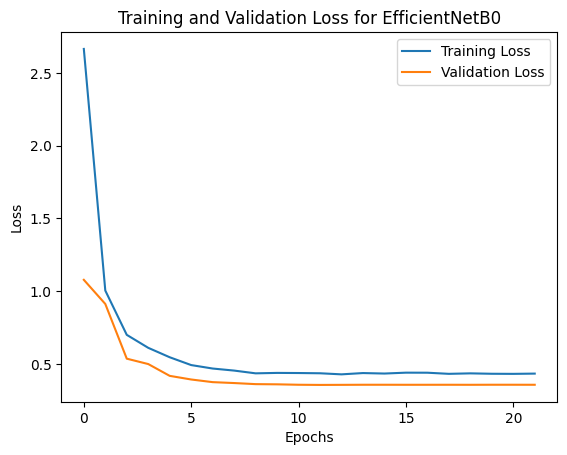

Classification Report:
              precision    recall  f1-score   support

   buildings     0.8800    0.9062    0.8929       437
      forest     0.9813    0.9958    0.9885       474
     glacier     0.8634    0.6745    0.7574       553
    mountain     0.8263    0.8248    0.8255       525
         sea     0.8136    0.9843    0.8909       510
      street     0.9093    0.9002    0.9047       501

    accuracy                         0.8757      3000
   macro avg     0.8790    0.8810    0.8766      3000
weighted avg     0.8772    0.8757    0.8729      3000

Confusion Matrix:
           buildings  forest  glacier  mountain  sea  street
buildings        396       1        0         0    2      38
forest             0     472        0         1    1       0
glacier            3       4      373        88   82       3
mountain           5       1       59       433   25       2
sea                2       2        0         2  502       2
street            44       1        0         0   

In [36]:
# Data generators
train_datagen = ImageDataGenerator(
    validation_split=0.2
)
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    '../data/deg_test',  
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    shuffle=False  
)

train_generator = train_datagen.flow_from_directory(
    '../data/seg_train_resized',
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '../data/seg_train_resized',
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    subset='validation'
)



base_models = {
   "EfficientNetB0": EfficientNetB0(weights='imagenet', include_top=False, pooling='avg'),
}

abel_scheduler = ABELScheduler( decay_factor=0.3, last_decay_epoch=100)


for name, base_model in base_models.items():
    print(f"Building model for {name}")
    model = build_model(base_model)

    model.compile(optimizer=Adam(learning_rate=0.01),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(f"Training {name}")

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=[early_stopping, abel_scheduler]
    )

    models[name] = model
    training_history[name] = history

    y_train_true = train_generator.classes
    y_train_pred_proba = model.predict(train_generator)

    y_val_true = validation_generator.classes
    y_val_pred_proba = model.predict(validation_generator)

    y_train_true_bin = label_binarize(y_train_true, classes=range(train_generator.num_classes))
    y_val_true_bin = label_binarize(y_val_true, classes=range(validation_generator.num_classes))

    train_auc = roc_auc_score(y_train_true_bin, y_train_pred_proba, average='weighted', multi_class='ovr')
    val_auc = roc_auc_score(y_val_true_bin, y_val_pred_proba, average='weighted', multi_class='ovr')

    train_precision = precision_score(y_train_true, np.argmax(y_train_pred_proba, axis=1), average='weighted')
    train_recall = recall_score(y_train_true, np.argmax(y_train_pred_proba, axis=1), average='weighted')
    train_f1 = f1_score(y_train_true, np.argmax(y_train_pred_proba, axis=1), average='weighted')

    val_precision = precision_score(y_val_true, np.argmax(y_val_pred_proba, axis=1), average='weighted')
    val_recall = recall_score(y_val_true, np.argmax(y_val_pred_proba, axis=1), average='weighted')
    val_f1 = f1_score(y_val_true, np.argmax(y_val_pred_proba, axis=1), average='weighted')

    print(f"{name} - Training Precision: {train_precision}, Recall: {train_recall}, F1: {train_f1}, AUC: {train_auc}")
    print(f"{name} - Validation Precision: {val_precision}, Recall: {val_recall}, F1: {val_f1}, AUC: {val_auc}")



    test_loss, test_accuracy = model.evaluate(test_generator)
 
    y_test_true = test_generator.classes
    y_test_pred_proba = model.predict(test_generator)
        
    y_test_true_bin = label_binarize(y_test_true, classes=range(test_generator.num_classes))
        
    test_auc = roc_auc_score(y_test_true_bin, y_test_pred_proba, average='weighted', multi_class='ovr')
    test_precision = precision_score(y_test_true, np.argmax(y_test_pred_proba, axis=1), average='weighted')
    test_recall = recall_score(y_test_true, np.argmax(y_test_pred_proba, axis=1), average='weighted')
    test_f1 = f1_score(y_test_true, np.argmax(y_test_pred_proba, axis=1), average='weighted')
        
    print(f"{name} - Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
    print(f"{name} - Test Precision: {test_precision}, Recall: {test_recall}, F1: {test_f1}, AUC: {test_auc}")

    name = "EfficientNetB0"
    history = training_history.get(name)
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"Training and Validation Loss for {name}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

class_labels = list(test_generator.class_indices.keys())

print("Classification Report:")
report = classification_report(y_test_true, y_test_pred, target_names=class_labels, digits=4)
print(report)


conf_matrix = confusion_matrix(y_test_true, y_test_pred)

conf_matrix_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
print("Confusion Matrix:")
print(conf_matrix_df)

models['EfficientNetB0'].save('efficientnet_b0.keras')



# efficientnetb0 without learning rate decay

Found 3000 images belonging to 6 classes.
Found 11231 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Building model for EfficientNetB0_nolrd
Training EfficientNetB0_nolrd
Epoch 1/100


2024-12-14 15:42:37.435186: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_23_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


88/88 ━━━━━━━━━━━━━━━━━━━━ 92s 902ms/step - accuracy: 0.7029 - loss: 4.3921 - val_accuracy: 0.8873 - val_loss: 2.1206
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 38s 411ms/step - accuracy: 0.8344 - loss: 1.6996 - val_accuracy: 0.8927 - val_loss: 0.9611
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 42s 452ms/step - accuracy: 0.8460 - loss: 0.8855 - val_accuracy: 0.8755 - val_loss: 0.6104
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 53s 565ms/step - accuracy: 0.8380 - loss: 0.6593 - val_accuracy: 0.8777 - val_loss: 0.5150
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 68s 736ms/step - accuracy: 0.8391 - loss: 0.6084 - val_accuracy: 0.8941 - val_loss: 0.4561
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 79s 856ms/step - accuracy: 0.8511 - loss: 0.5504 - val_accuracy: 0.8912 - val_loss: 0.4545
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 73s 773ms/step - accuracy: 0.8454 - loss: 0.5401 - val_accuracy: 0.8919 - val_loss: 0.4465
Epoch 8/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.8456 - loss: 0.5474 - val_accuracy: 

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 500ms/step - accuracy: 0.8874 - loss: 0.4582
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 331ms/step
EfficientNetB0_nolrd - Test Loss: 0.4619305729866028, Test Accuracy: 0.8866666555404663
EfficientNetB0_nolrd - Test Precision: 0.8869809397257641, Recall: 0.8866666666666667, F1: 0.8851210970041026, AUC: 0.9871740839906683


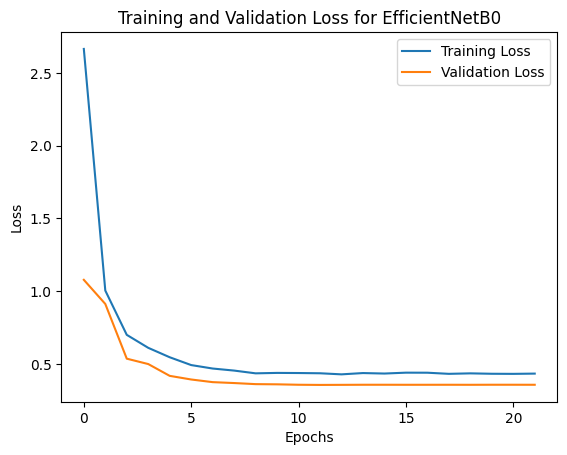

Classification Report:
              precision    recall  f1-score   support

   buildings     0.9078    0.9016    0.9047       437
      forest     0.9936    0.9852    0.9894       474
     glacier     0.8565    0.7342    0.7907       553
    mountain     0.8372    0.8229    0.8300       525
         sea     0.8418    0.9706    0.9016       510
      street     0.8996    0.9301    0.9146       501

    accuracy                         0.8867      3000
   macro avg     0.8894    0.8908    0.8885      3000
weighted avg     0.8870    0.8867    0.8851      3000

Confusion Matrix:
           buildings  forest  glacier  mountain  sea  street
buildings        394       0        0         0    3      40
forest             0     467        1         3    1       2
glacier            2       2      406        78   62       3
mountain           4       0       62       432   23       4
sea                3       1        5         3  495       3
street            31       0        0         0   

In [37]:
# Data generators
train_datagen = ImageDataGenerator(
    validation_split=0.2
)
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    '../data/deg_test',  
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    shuffle=False  
)

train_generator = train_datagen.flow_from_directory(
    '../data/seg_train_resized',
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '../data/seg_train_resized',
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    subset='validation'
)



base_models = {
   "EfficientNetB0_nolrd": EfficientNetB0(weights='imagenet', include_top=False, pooling='avg'),
}



for name, base_model in base_models.items():
    print(f"Building model for {name}")
    model = build_model(base_model)

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(f"Training {name}")

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=[early_stopping]
    )

    models[name] = model
    training_history[name] = history

    y_train_true = train_generator.classes
    y_train_pred_proba = model.predict(train_generator)

    y_val_true = validation_generator.classes
    y_val_pred_proba = model.predict(validation_generator)

    y_train_true_bin = label_binarize(y_train_true, classes=range(train_generator.num_classes))
    y_val_true_bin = label_binarize(y_val_true, classes=range(validation_generator.num_classes))

    train_auc = roc_auc_score(y_train_true_bin, y_train_pred_proba, average='weighted', multi_class='ovr')
    val_auc = roc_auc_score(y_val_true_bin, y_val_pred_proba, average='weighted', multi_class='ovr')

    train_precision = precision_score(y_train_true, np.argmax(y_train_pred_proba, axis=1), average='weighted')
    train_recall = recall_score(y_train_true, np.argmax(y_train_pred_proba, axis=1), average='weighted')
    train_f1 = f1_score(y_train_true, np.argmax(y_train_pred_proba, axis=1), average='weighted')

    val_precision = precision_score(y_val_true, np.argmax(y_val_pred_proba, axis=1), average='weighted')
    val_recall = recall_score(y_val_true, np.argmax(y_val_pred_proba, axis=1), average='weighted')
    val_f1 = f1_score(y_val_true, np.argmax(y_val_pred_proba, axis=1), average='weighted')

    print(f"{name} - Training Precision: {train_precision}, Recall: {train_recall}, F1: {train_f1}, AUC: {train_auc}")
    print(f"{name} - Validation Precision: {val_precision}, Recall: {val_recall}, F1: {val_f1}, AUC: {val_auc}")



    test_loss, test_accuracy = model.evaluate(test_generator)
 
    y_test_true = test_generator.classes
    y_test_pred_proba = model.predict(test_generator)
        
    y_test_true_bin = label_binarize(y_test_true, classes=range(test_generator.num_classes))
        
    test_auc = roc_auc_score(y_test_true_bin, y_test_pred_proba, average='weighted', multi_class='ovr')
    test_precision = precision_score(y_test_true, np.argmax(y_test_pred_proba, axis=1), average='weighted')
    test_recall = recall_score(y_test_true, np.argmax(y_test_pred_proba, axis=1), average='weighted')
    test_f1 = f1_score(y_test_true, np.argmax(y_test_pred_proba, axis=1), average='weighted')
        
    print(f"{name} - Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
    print(f"{name} - Test Precision: {test_precision}, Recall: {test_recall}, F1: {test_f1}, AUC: {test_auc}")

    name = "EfficientNetB0"
    history = training_history.get(name)
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"Training and Validation Loss for {name}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

class_labels = list(test_generator.class_indices.keys())

print("Classification Report:")
report = classification_report(y_test_true, y_test_pred, target_names=class_labels, digits=4)
print(report)


conf_matrix = confusion_matrix(y_test_true, y_test_pred)

conf_matrix_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
print("Confusion Matrix:")
print(conf_matrix_df)

models['EfficientNetB0_nolrd'].save('efficientnet_b0_nolrd.keras')



# VGG16

Found 3000 images belonging to 6 classes.
Found 11231 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Building model for VGG16
Training VGG16
Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.6665 - loss: 3.0188 - val_accuracy: 0.7917 - val_loss: 0.8445
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 81s 874ms/step - accuracy: 0.7500 - loss: 0.9171 - val_accuracy: 0.8442 - val_loss: 0.6961
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 80s 873ms/step - accuracy: 0.7563 - loss: 0.8832 - val_accuracy: 0.8263 - val_loss: 0.7873
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 896ms/step - accuracy: 0.7553 - loss: 0.8778 - val_accuracy: 0.8142 - val_loss: 0.7519
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 79s 868ms/step - accuracy: 0.7643 - loss: 0.8596 - val_accuracy: 0.8252 - val_loss: 0.7187
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 80s 873ms/step - accuracy: 0.7637 - loss: 0.8301 - val_accuracy: 0.8153 - val_loss: 0.7379
Epoc

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 950ms/step - accuracy: 0.8280 - loss: 0.5980
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 673ms/step
VGG16 - Test Loss: 0.5780054330825806, Test Accuracy: 0.8356666564941406
VGG16 - Test Precision: 0.8351888683242581, Recall: 0.8356666666666667, F1: 0.833833019735137, AUC: 0.9758286418141449


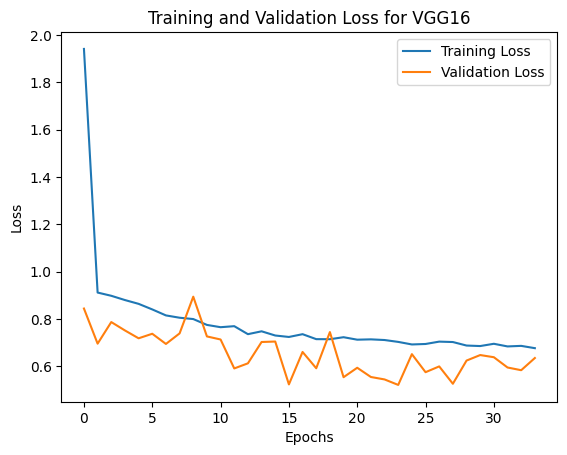

Classification Report:
              precision    recall  f1-score   support

   buildings     0.8889    0.8055    0.8451       437
      forest     0.9809    0.9768    0.9789       474
     glacier     0.7577    0.6673    0.7096       553
    mountain     0.7533    0.7562    0.7548       525
         sea     0.8427    0.9137    0.8768       510
      street     0.8142    0.9182    0.8630       501

    accuracy                         0.8357      3000
   macro avg     0.8396    0.8396    0.8380      3000
weighted avg     0.8352    0.8357    0.8338      3000

Confusion Matrix:
           buildings  forest  glacier  mountain  sea  street
buildings        352       2        0         0    4      79
forest             0     463        5         0    0       6
glacier            2       1      369       123   51       7
mountain           2       2       86       397   29       9
sea                3       3       27         7  466       4
street            37       1        0         0   

In [29]:
from tensorflow.keras.applications.vgg16 import preprocess_input

train_datagen = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=preprocess_input,
)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
                                 )

test_generator = test_datagen.flow_from_directory(
    '../data/deg_test',  
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    shuffle=False  
)

train_generator = train_datagen.flow_from_directory(
    '../data/seg_train_resized',
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '../data/seg_train_resized',
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    subset='validation'
)



base_models = {
   "VGG16": VGG16(weights='imagenet', include_top=False, pooling='avg')
}


for name, base_model in base_models.items():
    print(f"Building model for {name}")
    model = build_model(base_model)

    model.compile(optimizer=Adam(learning_rate=0.005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(f"Training {name}")

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=[early_stopping]
    )

    models[name] = model
    training_history[name] = history

    y_train_true = train_generator.classes
    y_train_pred_proba = model.predict(train_generator)

    y_val_true = validation_generator.classes
    y_val_pred_proba = model.predict(validation_generator)

    y_train_true_bin = label_binarize(y_train_true, classes=range(train_generator.num_classes))
    y_val_true_bin = label_binarize(y_val_true, classes=range(validation_generator.num_classes))

    train_auc = roc_auc_score(y_train_true_bin, y_train_pred_proba, average='weighted', multi_class='ovr')
    val_auc = roc_auc_score(y_val_true_bin, y_val_pred_proba, average='weighted', multi_class='ovr')

    train_precision = precision_score(y_train_true, np.argmax(y_train_pred_proba, axis=1), average='weighted')
    train_recall = recall_score(y_train_true, np.argmax(y_train_pred_proba, axis=1), average='weighted')
    train_f1 = f1_score(y_train_true, np.argmax(y_train_pred_proba, axis=1), average='weighted')

    val_precision = precision_score(y_val_true, np.argmax(y_val_pred_proba, axis=1), average='weighted')
    val_recall = recall_score(y_val_true, np.argmax(y_val_pred_proba, axis=1), average='weighted')
    val_f1 = f1_score(y_val_true, np.argmax(y_val_pred_proba, axis=1), average='weighted')

    print(f"{name} - Training Precision: {train_precision}, Recall: {train_recall}, F1: {train_f1}, AUC: {train_auc}")
    print(f"{name} - Validation Precision: {val_precision}, Recall: {val_recall}, F1: {val_f1}, AUC: {val_auc}")



    test_loss, test_accuracy = model.evaluate(test_generator)
 
    y_test_true = test_generator.classes
    y_test_pred_proba = model.predict(test_generator)
        
    y_test_true_bin = label_binarize(y_test_true, classes=range(test_generator.num_classes))
        
    test_auc = roc_auc_score(y_test_true_bin, y_test_pred_proba, average='weighted', multi_class='ovr')
    test_precision = precision_score(y_test_true, np.argmax(y_test_pred_proba, axis=1), average='weighted')
    test_recall = recall_score(y_test_true, np.argmax(y_test_pred_proba, axis=1), average='weighted')
    test_f1 = f1_score(y_test_true, np.argmax(y_test_pred_proba, axis=1), average='weighted')
        
    print(f"{name} - Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
    print(f"{name} - Test Precision: {test_precision}, Recall: {test_recall}, F1: {test_f1}, AUC: {test_auc}")

    name = "VGG16"
    history = training_history.get(name)
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"Training and Validation Loss for {name}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

class_labels = list(test_generator.class_indices.keys())

print("Classification Report:")
report = classification_report(y_test_true, y_test_pred, target_names=class_labels, digits=4)
print(report)


conf_matrix = confusion_matrix(y_test_true, y_test_pred)

conf_matrix_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
print("Confusion Matrix:")
print(conf_matrix_df)

models['VGG16'].save('vgg_16.keras')


### Comparison of Models

| Model          | Accuracy | Macro Precision | Macro Recall | Macro F1-Score | Strengths                                                                                     | Weaknesses                                                                                  |
|----------------|----------|-----------------|--------------|----------------|-----------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------|
| **ResNet-50**  | 87.7%    | 87.9%           | 88.0%        | 87.86%         | - High performance for forest (F1: 97.87%) and sea (F1: 90.99%).                             | - Lower F1-scores for glacier (80.15%) and mountain (78.61%).                              |
| **ResNet-101** | 86.1%    | 86.57%          | 86.59%       | 86.13%         | - High recall for forest (99.79%).                                                           | - Glacier has a very low F1-score (73.34%) due to recall (62.93%). Mountain is weak (78.4%).|
| **EfficientNet-B0** | 88.67%   | 88.94%          | 89.08%       | 88.85%         | - Strong performance across most classes; forest (F1: 98.94%) and sea/street above 90%.       | - Glacier (79.07%) and mountain (83.0%) show slightly lower performance.                   |
| **VGG16**      | 83.57%   | 83.96%          | 83.96%       | 83.38%         | - Forest performs well (F1: 97.89%).                                                         | - Overall the weakest model; glacier (70.96%) and mountain (75.48%) significantly underperform. |

---

### Best Model:
**EfficientNet-B0**:
- **Accuracy**: Highest among all models (88.67%).
- **Strengths**: Balanced performance across classes with strong generalization.
- **Weaknesses**: Slightly lower F1-scores for glacier and mountain.

ResNet-50 can also be considered for its close performance and computational efficiency, but VGG16 is not recommended due to overall weaker metrics.
G16** underperforms significantly and is not recommended.


# Sources
- To use resizing or zero padding? - https://link.springer.com/article/10.1186/s40537-019-0263-7 (either method doesn't impact accuracy but zero padding is slightly faster)
- choosing interpolation with bicubic - https://www.atlantis-press.com/proceedings/iccsee-13/4822
- learning rate decay improves accuracy - https://arxiv.org/abs/1908.01878,
- ABEL early stopping - https://arxiv.org/abs/2103.12682
